In [1]:
import os

images_num = 0
image_names_dict = {}

for dirname, _, filenames in os.walk('D:\datasets\deforestation'):
    for filename in filenames:
        if filename.endswith('_TCI.jp2'):
            images_num += 1 
            if dirname not in image_names_dict:
                image_names_dict[dirname] = list()
            image_names_dict[dirname].append(filename)

print(images_num)
#image_names_dict

10


In [2]:
image_paths_list = [os.path.join(dirname, filename) for dirname, filenames in image_names_dict.items() for filename in filenames]
image_paths_list

['D:\\datasets\\deforestation\\S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE\\GRANULE\\L1C_T36UYA_A003350_20160212T084510\\IMG_DATA\\T36UYA_20160212T084052_TCI.jp2',
 'D:\\datasets\\deforestation\\S2A_MSIL1C_20160330T082542_N0201_R021_T36UYA_20160330T082810.SAFE\\GRANULE\\L1C_T36UYA_A004022_20160330T082810\\IMG_DATA\\T36UYA_20160330T082542_TCI.jp2',
 'D:\\datasets\\deforestation\\S2A_MSIL1C_20160405T085012_N0201_R107_T36UYA_20160405T085012.SAFE\\GRANULE\\L1C_T36UYA_A004108_20160405T085012\\IMG_DATA\\T36UYA_20160405T085012_TCI.jp2',
 'D:\\datasets\\deforestation\\S2A_MSIL1C_20160502T083602_N0201_R064_T36UYA_20160502T084425.SAFE\\GRANULE\\L1C_T36UYA_A004494_20160502T084425\\IMG_DATA\\T36UYA_20160502T083602_TCI.jp2',
 'D:\\datasets\\deforestation\\S2A_MSIL1C_20160509T082612_N0202_R021_T36UYA_20160509T083548.SAFE\\GRANULE\\L1C_T36UYA_A004594_20160509T083548\\IMG_DATA\\T36UYA_20160509T082612_TCI.jp2',
 'D:\\datasets\\deforestation\\S2A_MSIL1C_20160618T082602_N0204_R021_T

In [3]:
import rasterio
from rasterio.plot import reshape_as_image

# Indexes of images from image_paths_list
#read_image_indexes = list(range(24))
read_image_indexes = [0, 2, 4, 9]

images = []

def read_raster_image(path):
    with rasterio.open(path, "r", driver='JP2OpenJPEG') as src:
        raster_image = src.read()
        raster_meta = src.meta
    raster_image = reshape_as_image(raster_image)
    return raster_image, raster_meta

for i in read_image_indexes:
    image_path = image_paths_list[i]
    image, meta = read_raster_image(image_path)
    images.append(image)
    print(f'Raster image {i} was read, shape: {image.shape}')
    #print(f'metadata: {meta}\n')

Raster image 0 was read, shape: (10980, 10980, 3)
Raster image 2 was read, shape: (10980, 10980, 3)
Raster image 4 was read, shape: (10980, 10980, 3)
Raster image 9 was read, shape: (10980, 10980, 3)


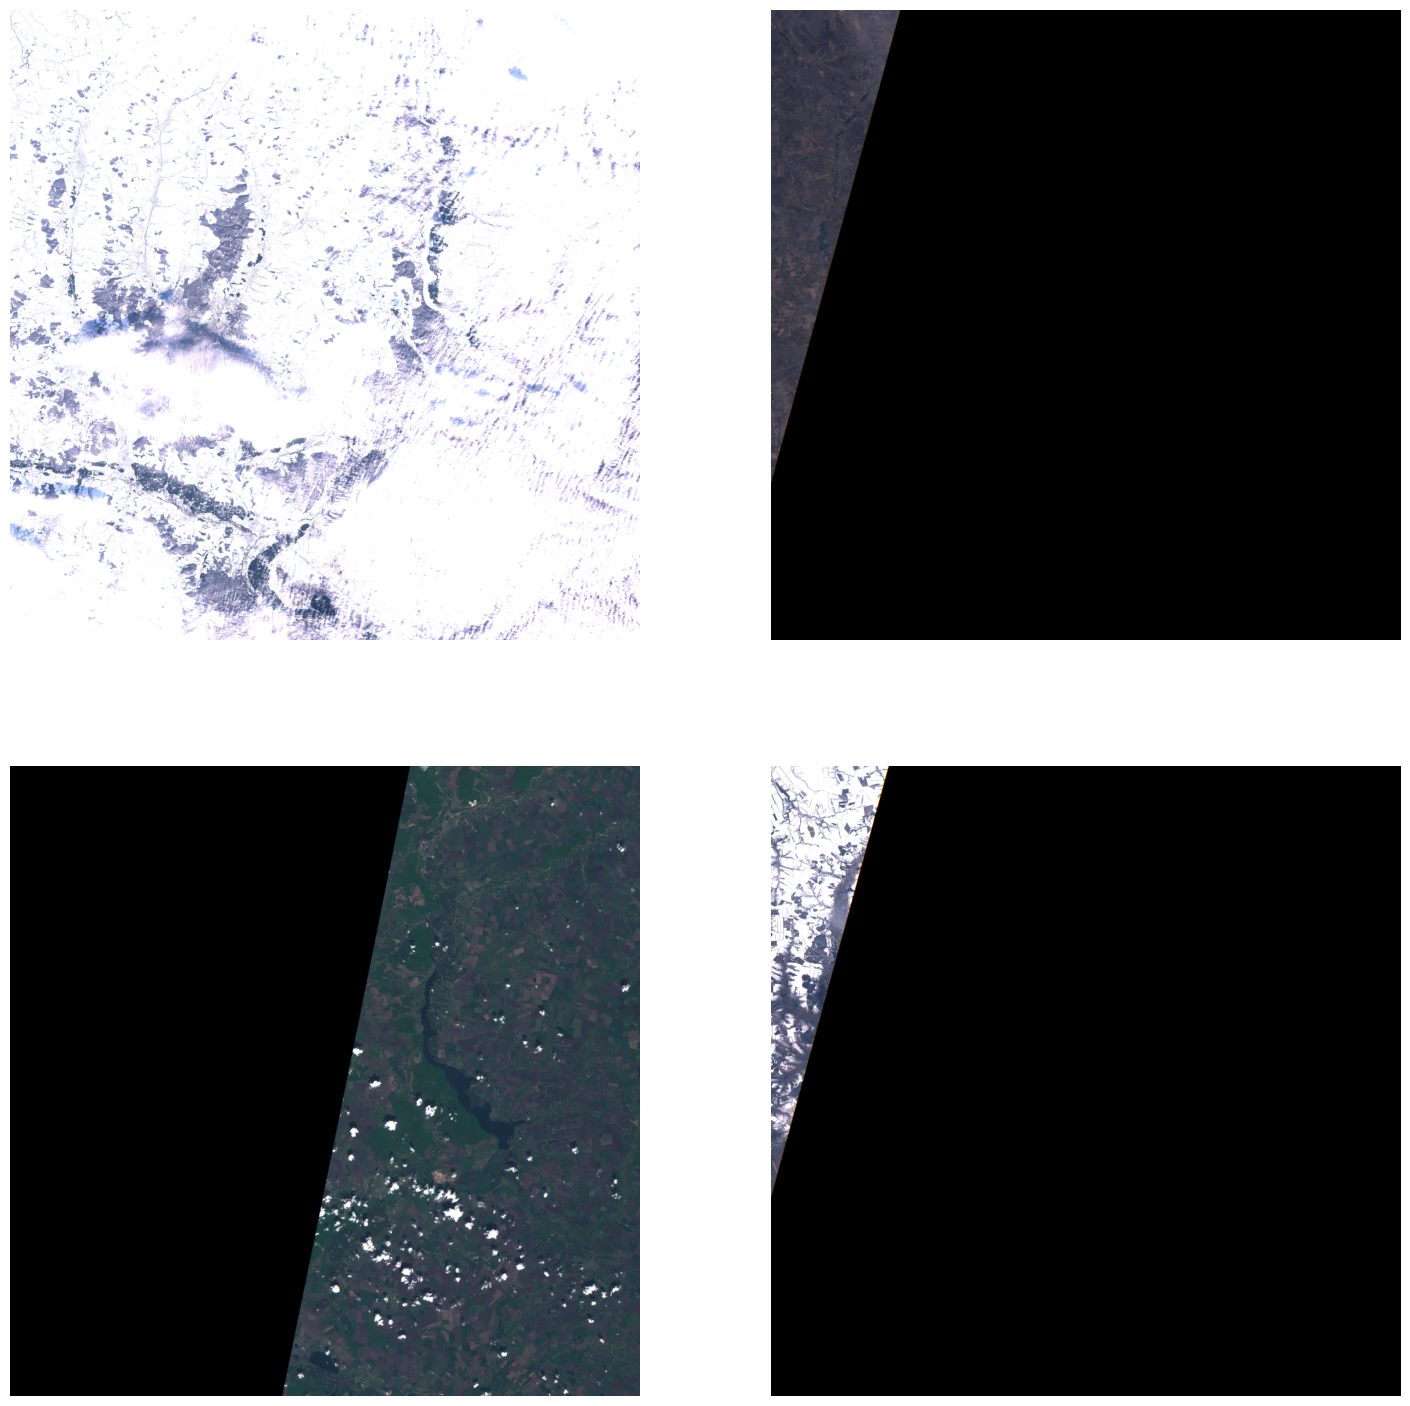

In [4]:
import cv2
import matplotlib.pyplot as plt

dscale_images = [cv2.resize(image, None, fx=0.1, fy=0.1, interpolation=cv2.INTER_AREA) for image in images]

#fig, ax = plt.subplots(ncols=3, nrows=8, figsize=(18, 48))
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 18))
ax = ax.flatten()

for i in range(len(dscale_images)):
    ax[i].imshow(dscale_images[i])
    ax[i].axis('off')
    
plt.show()

In [5]:
import torch
import kornia as K
from kornia_moons.viz import draw_LAF_matches

class LoFTR_Matcher:
    # image_size - size of scaled images used in LoFTR, if it is None then the source images
    # or images with the calculated scale are used. For best matching performance,
    # the source image size should be a multiple of image_size.
    def __init__(self, image_size=None, device=None):
        self.image_size = image_size
        self.device = device if device else K.utils.get_cuda_device_if_available()
        self.matcher = K.feature.LoFTR(pretrained='outdoor').eval().to(self.device)
        
    def __call__(self, image0, image1, confidence_min=0.8, accurate=False):
        image0 = self._convert_image(image0)
        image1 = self._convert_image(image1)
        
        input = {            
            'image0': K.color.rgb_to_grayscale(image0), # LoFTR works on grayscale images only
            'image1': K.color.rgb_to_grayscale(image1)
        }        
        with torch.inference_mode():
            corresp = self.matcher(input)

        # Select key points that have a confidence greater than confidence_min
        mask = corresp['confidence'] > confidence_min
        indices = torch.nonzero(mask, as_tuple=True)               
        keypoints0 = corresp['keypoints0'][indices].cpu().numpy()
        keypoints1 = corresp['keypoints1'][indices].cpu().numpy()
        confidence = corresp['confidence'][indices].cpu().numpy()

        # From confidence key points we select inlier points relative to the fundamental matrix
        fmat_method = cv2.USAC_ACCURATE if accurate else cv2.USAC_MAGSAC
        try:
            fmat, inliers = cv2.findFundamentalMat(keypoints0, keypoints1, fmat_method, 1, 0.99, 100000)
            inliers = inliers > 0
        except:
            inliers = None        
        
        return {
            'image0' : image0,
            'image1' : image1,
            'keypoints0': keypoints0,
            'keypoints1': keypoints1,
            'confidence': confidence,
            'inliers': inliers
        }        

    @staticmethod
    def draw_matches(match_dict):        
        output_fig = draw_LAF_matches(
            K.feature.laf_from_center_scale_ori(
                torch.from_numpy(match_dict['keypoints0']).view(1, -1, 2),
                torch.ones(match_dict['keypoints0'].shape[0]).view(1, -1, 1, 1),
                torch.ones(match_dict['keypoints0'].shape[0]).view(1, -1, 1),
            ),
            K.feature.laf_from_center_scale_ori(
                torch.from_numpy(match_dict['keypoints1']).view(1, -1, 2),
                torch.ones(match_dict['keypoints1'].shape[0]).view(1, -1, 1, 1),
                torch.ones(match_dict['keypoints1'].shape[0]).view(1, -1, 1),
            ),
            torch.arange(match_dict['keypoints0'].shape[0]).view(-1, 1).repeat(1, 2),
            K.tensor_to_image(match_dict['image0']),
            K.tensor_to_image(match_dict['image1']),
            match_dict['inliers'],
            draw_dict={
                'inlier_color': (0.2, 1, 0.2),
                'tentative_color': (1, 0.1, 0.1),
                'feature_color': (0.2, 0.5, 1),
                'vertical': False}
        )
        return output_fig        
        
    def _convert_image(self, image):
        SIZE_MAX = 1280 # LoFTR has out of memory for large images
        image = K.utils.image_to_tensor(image)
        image = image.float().unsqueeze(dim=0).to(self.device) / 255.0
        if self.image_size:
            image = K.geometry.resize(image, self.image_size, interpolation='area')
        elif max(image.shape[-1], image.shape[-2]) > SIZE_MAX:
            image = K.geometry.resize(image, SIZE_MAX, side='long', interpolation='area')
        return image

C:\Users\Andrey\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# For best matching performance, an input image size should be a multiple of IMAGE_SIZE
IMAGE_SIZE = (1098, 1098)

matcher = LoFTR_Matcher(IMAGE_SIZE)

def outputs_matches(image0, image1, conf=0.8, accurate=False):    
    corresp = matcher(image0, image1, conf, accurate)
    keypoints_num = len(corresp['inliers'])
    inliers_num = sum(corresp['inliers'])[0]
    ratio = inliers_num / float(keypoints_num)
    
    print(f'key points: {keypoints_num}, inlier points: {inliers_num}, ratio: {ratio:.2f}')    
    matcher.draw_matches(corresp)

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to C:\Users\Andrey/.cache\torch\hub\checkpoints\loftr_outdoor.ckpt

00%|█████████████████████████████████████████████████████████████████████████████| 44.2M/44.2M [00:06<00:00, 6.63MB/s]

key points: 10, inlier points: 10, ratio: 1.00


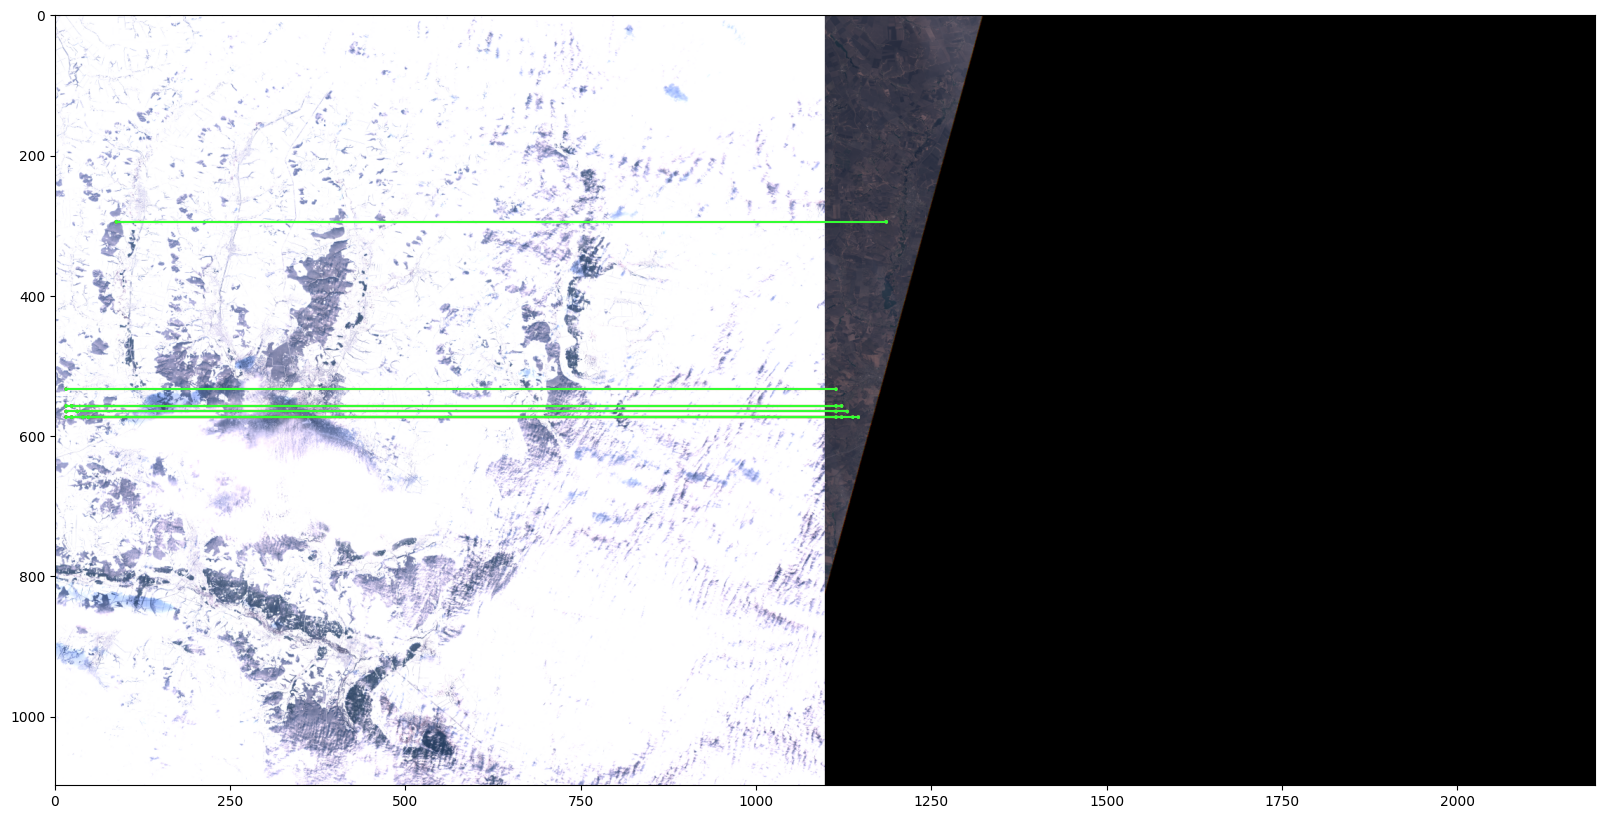

In [7]:
outputs_matches(images[0], images[1])

key points: 23, inlier points: 22, ratio: 0.96


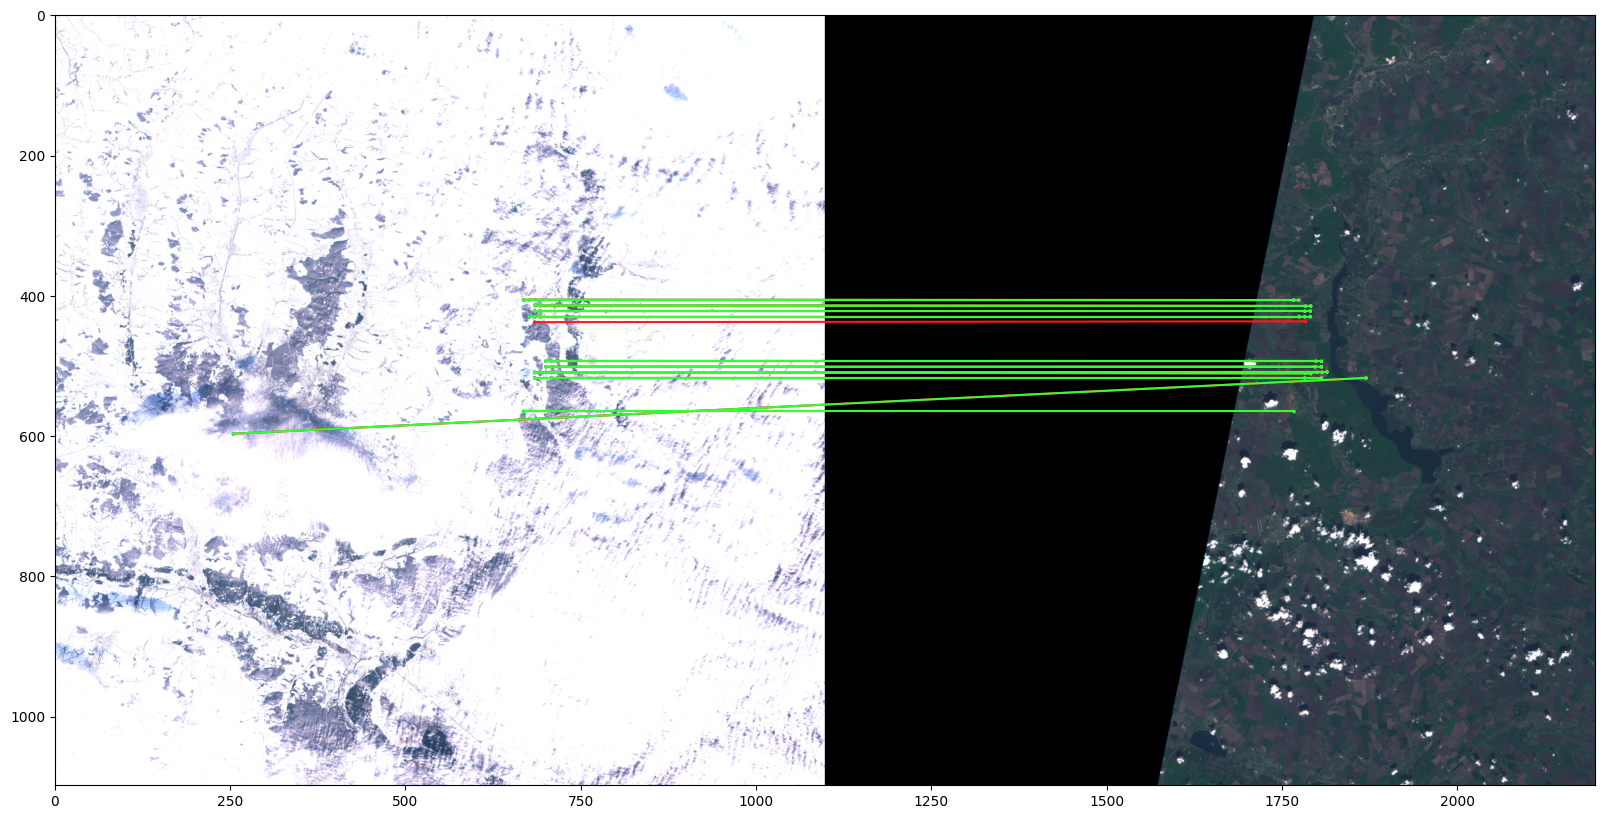

In [9]:
outputs_matches(images[0], images[2], accurate=True)

In [1]:
!pipreqsnb "D:\projects"

pipreqs  D:\projects


INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in D:\projects\requirements.txt
